In [420]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the dataset
DKI1 = pd.read_excel("Forecast.xlsx", sheet_name="DKI1")
X = DKI1.index.values.reshape(-1, 1)
y = DKI1['SO2'].values.reshape(-1,)

# Define the forecast horizon
forecast_horizon = 31

In [421]:
# Making Train-Test Splits and Data Normalisation
m = 14
per = (0.8 * (len(X) - forecast_horizon) - m) / (len(X) - forecast_horizon)
size = int(len(X) * per)
X_train, X_test = X[0:size], X[size:len(X)]
y_train, y_test = y[0:size], y[size:len(y)]
mean_train = np.mean(y_train)
sd_train = np.std(y_train)
y_train = (y_train - mean_train) / sd_train
y_test = (y_test - mean_train) / sd_train

# Combine train and test data
X_data, y_data = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))

In [422]:
# Reshape the data into the form that needs to be fed into the ELM
def reshape_data(data, m):
    X_data, y_data = [], []
    for i in range(len(data) - m):
        X_data.append(data[i:i + m])
        y_data.append(data[i + m])
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

X_data, y_data = reshape_data(y_data, m)


In [423]:
# Building the ELM model
input_size = X_data.shape[1]
hidden_size = 1000  # no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1
w_hi = 1
b_lo = -1
b_hi = 1

# Initializing input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,
                                    size=[input_size, hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,
                             size=[hidden_size])


def elu(x):
    alpha = 1.0  # ELU hyperparameter (can be adjusted)
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = elu(G)
    return H

output_weights = np.dot(pinv(hidden_nodes(X_data)), y_data)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

In [424]:
# Make predictions for the forecast horizon
X_forecast = X_data[-1:, :]
forecast = []
for _ in range(forecast_horizon):
    prediction = predict(X_forecast)
    forecast.append(prediction)
    # Update X_forecast with the predicted value for the next iteration
    X_forecast = np.concatenate((X_forecast[:, 1:], prediction.reshape(1, 1)), axis=1)

# Denormalize the forecasted values
forecast = np.array(forecast)
forecast = (forecast * sd_train) + mean_train


C:\Users\user\AppData\Local\Temp\ipykernel_4256\2513291900.py:19: RuntimeWarning: overflow encountered in exp
  return np.where(x >= 0, x, alpha * (np.exp(x) - 1))


In [425]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Mengubah data aktual ke dalam bentuk semula (sebelum dinormalisasi)
y_actual = (y_data[-forecast_horizon:] * sd_train) + mean_train

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_actual, forecast))
mse = mean_squared_error(y_actual, forecast)
mae = mean_absolute_error(y_actual, forecast)
r2 = r2_score(y_actual, forecast)




In [426]:
# Print the evaluation metrics
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)
print('R-squared: %.3f' % r2)

RMSE: 291.788
MSE: 85140.333
MAE: 125.130
R-squared: -25678117.228


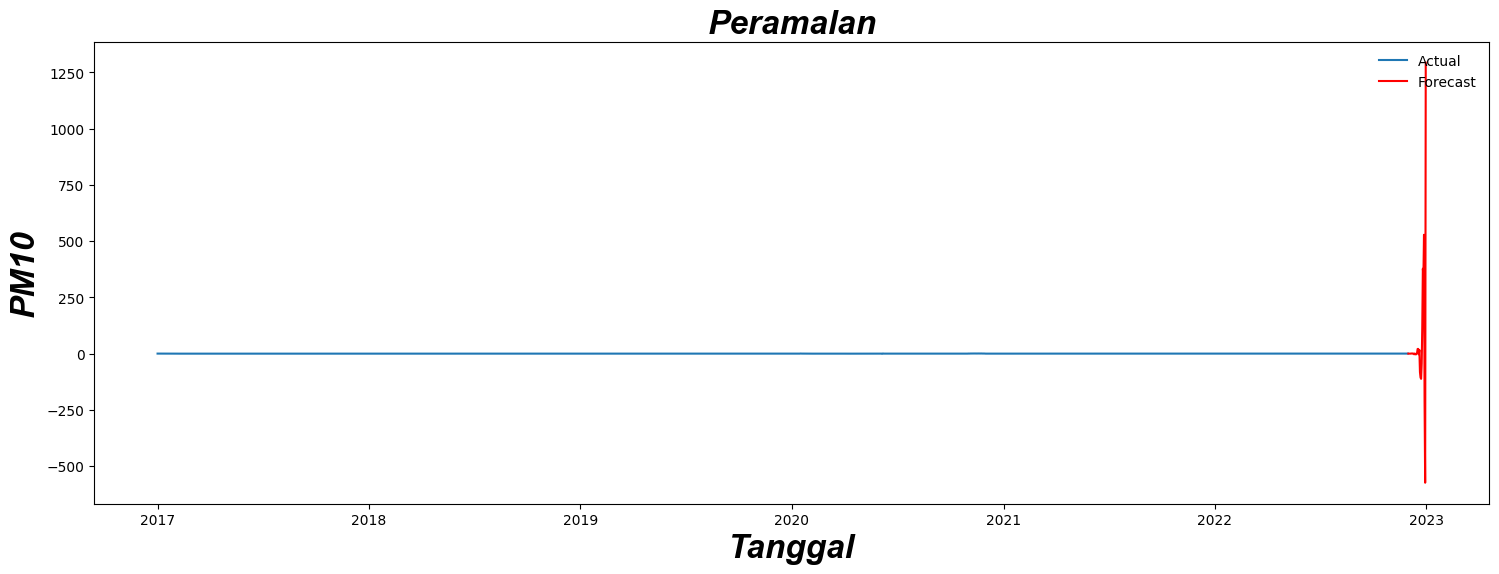

In [427]:
# Plot the actual data and forecasted values
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot_date(DKI1['Tanggal'], y, '-', label='Actual')
forecast_dates = DKI1['Tanggal'].iloc[-1] + pd.to_timedelta(np.arange(1, forecast_horizon + 1), unit='D')
ax.plot_date(forecast_dates, forecast.flatten(), '-', color='red', label='Forecast')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Tanggal', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('PM10', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Peramalan', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.show()

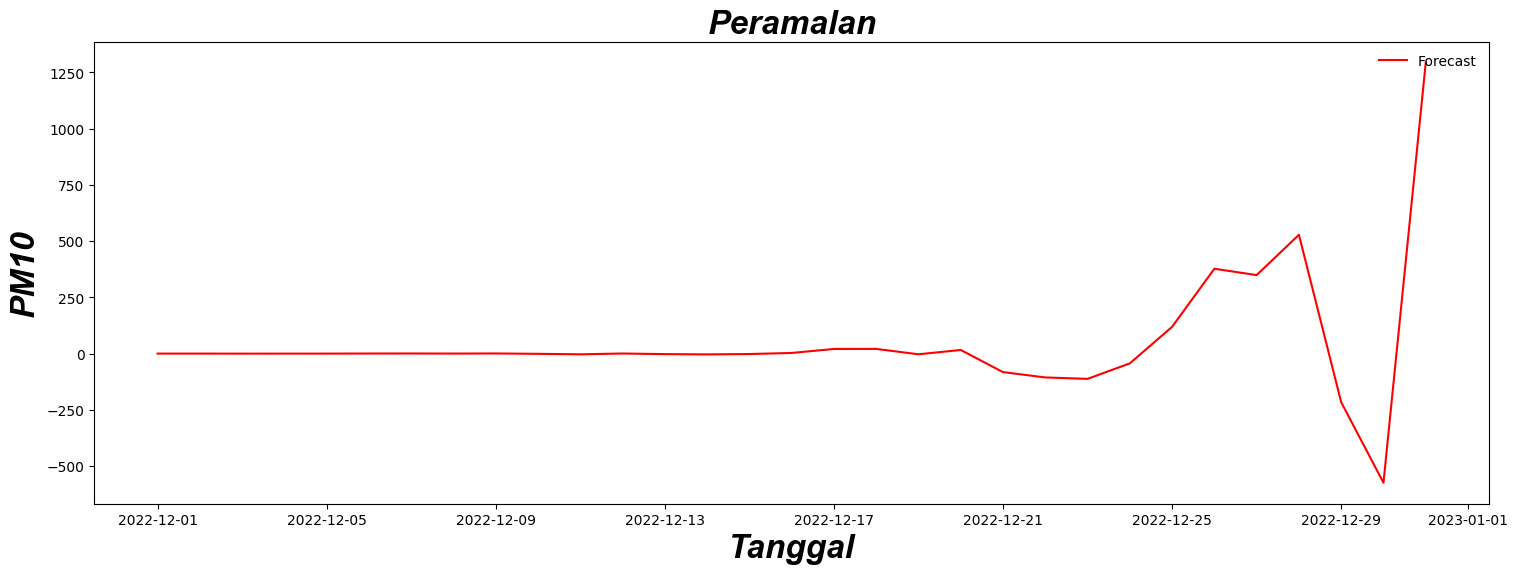

In [428]:
import matplotlib.pyplot as plt

# Plot the forecasted values
fig, ax = plt.subplots(figsize=(18, 6))
forecast_dates = DKI1['Tanggal'].iloc[-1] + pd.to_timedelta(np.arange(1, forecast_horizon + 1), unit='D')
ax.plot_date(forecast_dates, forecast.flatten(), '-', color='red', label='Forecast')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Tanggal', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('PM10', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Peramalan', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.show()


In [429]:
# Create a DataFrame with 'Tanggal' and 'Forecast' columns
df_forecast = pd.DataFrame({
    'Tanggal': forecast_dates,
    'Forecast': forecast.flatten()
})

# Display the DataFrame
print(df_forecast)

      Tanggal     Forecast
0  2022-12-01     0.331706
1  2022-12-02     0.366310
2  2022-12-03     0.086082
3  2022-12-04     0.188860
4  2022-12-05     0.284357
5  2022-12-06     0.641251
6  2022-12-07     0.809185
7  2022-12-08     0.436848
8  2022-12-09     0.924483
9  2022-12-10    -0.728419
10 2022-12-11    -2.890854
11 2022-12-12     0.683312
12 2022-12-13    -2.017947
13 2022-12-14    -3.220108
14 2022-12-15    -1.653795
15 2022-12-16     3.156023
16 2022-12-17    20.948242
17 2022-12-18    21.191278
18 2022-12-19    -2.758160
19 2022-12-20    16.429429
20 2022-12-21   -82.016075
21 2022-12-22  -105.706273
22 2022-12-23  -111.981101
23 2022-12-24   -43.162229
24 2022-12-25   119.295108
25 2022-12-26   377.532974
26 2022-12-27   349.251939
27 2022-12-28   528.516268
28 2022-12-29  -216.030736
29 2022-12-30  -573.719537
30 2022-12-31  1293.401248
